# EMBED Data Engineering


![embed_logical_steps](images/embed_logical_steps.png)

## Defining our clinical sample

An understanding of the basic diagnostic pathway for breast cancer is important to working with EMBED. The graphic below shows a basic summary of the standard pathway for most patients.

![0_full_pathway](images/0_full_pathway.png)

---
# 1. Clinical Sample Selection

---
# 1a. Screening Abnormal vs Normal


### Objectives: 

1. **Positive group**:
    - Screening BIRADS 0
2. **Negative group**:
    - Screening BIRADS 1/2


![1a](images/1a.png)

## 1a.1. Prep
> ## You should be using the `pandas` environment!

In [37]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import pickle
from IPython.display import display
import pydicom
from dataclasses import dataclass, field
from tableone import TableOne

# these let us set the number of rows/cols of our dataframes we want to see
# EMBED has a lot of columns so it's a good idea to increase this from the default
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [38]:
def dataframe_stats(df, title: str or None = None):
    """
    helper function to check the number of patients, exams, and images/findings in a df
    """
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {df.png_path.nunique()}\n")
    else:
        print(f"Findings: {len(df)}\n")

The tables for EMBED can be found in `/fsx/embed/emory-mammo/tables/`. There are two versions of both Magview and metadata, one containing a reduced set of important columns, and one containing all columns. This notebook uses the full datasets and defines a specific subset to keep, but the reduced set should be suitable for most tasks.

In [39]:
os.listdir('/fsx/embed/emory-mammo/tables')

['filtered_magview.csv',
 'filtered_magview_reduced.csv',
 '.aws-datasync',
 'filtered_metadata.csv',
 'filtered_metadata_MRI_anon.csv',
 'filtered_metadata_reduced.csv']

In [40]:
# we're working with 20% of the total data today (and during the datathon)
mag_df = pd.read_csv("/fsx/embed/emory-mammo/tables/filtered_magview.csv", dtype=str)
meta_df = pd.read_csv("/fsx/embed/emory-mammo/tables/filtered_metadata.csv", dtype=str)

In [41]:
dataframe_stats(mag_df, 'magview')
dataframe_stats(meta_df, 'metadata')


magview
Patients: 32463
Exams: 90497
Findings: 105731


metadata
Patients: 31998
Exams: 86221
Images: 567152



In [42]:
meta_cols = [
    "empi_anon",
    "acc_anon",
    "ImageLateralityFinal",
    "ViewPosition",
    "study_date_anon",
    "FinalImageType",
    "png_path",
    "anon_dicom_path",
    "StudyDescription",
    "ROI_match_level",
    "num_roi",
    "PNG_ROI_coords",
    "DCM_ROI_coords",
    "spot_mag"
]

mag_cols = [
    "empi_anon",
    "acc_anon",
    "study_date_anon",
    "desc",
    "side",
    "asses",
    "path_severity",
    "bside",
    'procdate_anon',
    'pdate_anon',
    'massshape', 
    'massmargin', 
    'massdens', 
    'calcdistri', 
    'calcfind', 
    'calcnumber',
    'tissueden',
    "ETHNICITY_DESC", 
    "ETHNIC_GROUP_DESC", 
    "MARITAL_STATUS_DESC", 
    "age_at_study",
    "numfind"
]

##### Check datatypes

In [43]:
# only keep the subset of columns we need
# we'll need to re-load the magview/metadata CSVs if we want additional columns
meta_df = meta_df[meta_cols]
mag_df = mag_df[mag_cols]

# we need to ensure our date columns are read as dates
meta_df.study_date_anon = pd.to_datetime(meta_df.study_date_anon)
mag_df.study_date_anon = pd.to_datetime(mag_df.study_date_anon)

# and our numeric columns are read as numeric
meta_df.num_roi = meta_df.num_roi.astype(int)
meta_df.num_roi = pd.to_numeric(meta_df.num_roi)
mag_df.path_severity = pd.to_numeric(mag_df.path_severity)

## 1a.2. Screening

Screening and diagnostic exams can be most easily differentiated with the 'desc' column which contains the description of the study
![1_screening](images/1_screening.png)

In [44]:
mag_df.desc.value_counts()

desc
MG Screen Bilat w/Tomo/CAD Stnd Protocol    48061
MG Diagnostic Bilateral w/ CAD              11246
MG Screening Bilateral                       9885
MG Screening Bilateral w/CAD                 7385
MG Diagnostic Left w/CAD                     5502
MG Diagnostic Right w/CAD                    5460
MG Diagnostic Mammo Bilateral                4680
MG Diagnostic Left                           3060
MG Diagnostic Right                          2984
MG Diagnostic Bilateral w/Tomo/CAD           2344
MG Screening Left w/Tomo/CAD                  943
MG Diagnostic  Right w/Tomo/CAD               880
MG Diagnostic  Left w/Tomo/CAD                870
MG Screening Right w/Tomo/CAD                 857
MG Diagnostic Bilateral w/Tomosynthesis       404
MG Screening Right w/CAD                      360
MG Screening Left w/CAD                       297
MG Screening Bilat w/Tomosynthesis            132
MG Screening Left                             119
MG Screening Right                           

In [45]:
mag_screen = mag_df.loc[mag_df.desc.str.contains("scr", case=False)].copy()


In [46]:
dataframe_stats(mag_screen, 'magview screen')



magview screen
Patients: 25086
Exams: 63399
Findings: 68144



> ## Question
>
> **If we wanted to filter for diagnostic exams instead, how do you think we could achieve this?**

## 1a.3. Correct Contralaterals

- MAGVIEW only has entries if a finding exists.
- This means that if an exam is a bilateral exam and only one of the breast has a finding, the contralateral breast (negative) won't have an entry.
- This would be problematic at the time when we need to merge with METADATA, because the contralateral breast would be excluded.
- Therefore, we would need to create rows for the negative contralateral breast.
![contralat_correction](images/contralat_correction.png)

In [47]:
def get_exam_laterality(row):
    # extract description and lowercase it
    finding_desc = row.desc.lower()
    
    if ("bilat" in finding_desc):
        return "B"
    elif ("left" in finding_desc):
        return "L"
    elif ("right" in finding_desc):
        return "R"
    else:
        return None

def apply_contralateral_correction(df):
    """
    function to apply a contralateral finding correction to a dataframe of screening exams
    """
    # apply the get_exam_laterality function to extract laterality from each desc
    df["exam_laterality"] = df.apply(get_exam_laterality, axis=1)
    
    # side == nan --> B
    df.side = df.side.fillna("B")
    
    # create copy for assigning B to R
    df_r = df.loc[df.side=="B"].copy()
    df_r.side = df.side.str.replace("B", "R")
    
    # assigning B to L
    df.side = df.side.str.replace("B", "L")
    
    # appending R and L
    df = pd.concat([df, df_r])
    
    df = df.sort_values(["empi_anon", "acc_anon", "study_date_anon"]).drop_duplicates()
    
    exam_lat_b = df.loc[df.exam_laterality=="B"]
    
    # We want to aggregate all the sides for each bilateral exam so that we can filter those having only a single side.
    exam_lat_b_agg = exam_lat_b.groupby('acc_anon')['side'].apply(''.join).reset_index()
    
    exam_lat_b_side_r = exam_lat_b_agg.loc[~(exam_lat_b_agg.side.str.contains("L"))].copy()
    exam_lat_b_side_l = exam_lat_b_agg.loc[~(exam_lat_b_agg.side.str.contains("R"))].copy()
    
    df_r_to_l = df.loc[df.acc_anon.isin(exam_lat_b_side_r.acc_anon)].copy().drop_duplicates()
    df_l_to_r = df.loc[df.acc_anon.isin(exam_lat_b_side_l.acc_anon)].copy().drop_duplicates()
    
    # Creating the negative Left side
    df_r_to_l.loc[df_r_to_l.side=="R", "side"] = "L"
    df_r_to_l.loc[df_r_to_l.side=="L", "asses"] = "N"
    df_r_to_l.loc[df_r_to_l.side=="L", "path_severity"] = np.nan
    
    # Creating the negative Right side
    df_l_to_r.loc[df_l_to_r.side=="L", "side"] = "R"
    df_l_to_r.loc[df_l_to_r.side=="R", "asses"] = "N"
    df_l_to_r.loc[df_l_to_r.side=="R", "path_severity"] = np.nan
    
    # Merging the original and the two negative contralaterals
    df_contralat = pd.concat([df, df_l_to_r, df_r_to_l]).sort_values(["empi_anon", "acc_anon", "study_date_anon"]).drop_duplicates()
    return df_contralat

# apply contralateral correction
mag_screen_with_contralat = apply_contralateral_correction(mag_screen)

In [48]:
dataframe_stats(mag_screen_with_contralat, 'magview screen with contralat')


magview screen with contralat
Patients: 25086
Exams: 63399
Findings: 129439



In [49]:
# verify finding lateralities
mag_screen_with_contralat.side.value_counts(dropna=False)

side
L    64744
R    64695
Name: count, dtype: int64

> ## Question:
>
> **We have:**
>
> **1. filtered Magview to only contain screening exams and**
> 
> **2. corrected missing contralateral negative findings.**
> 
> **If we want to define a screening normal versus abnormal  sample, what's our next step?**

| BIRADS | `asses` | Stage | Meaning |
| :-: | :-: | :-: | :-- |
| 0 | 'A' | Screen | Additional evaluation |
| 1 | 'N' | Screen + Diag | Negative |
| 2 | 'B' | Screen + Diag | Benign |
| 3 | 'P' | Diag | Probably benign |
| 4 | 'S' | Diag | Suspicious |
| 5 | 'M' | Diag | Highly suggestive of malignacy |
| 6 | 'K' | Diag | Known biopsy proven |

> Finding BIRADS score can be indexed with the `asses` column
> ![1.1_screening](images/1.1_screening.png)

In [50]:
mag_screen_with_contralat.asses.value_counts(dropna=False)

asses
N    102421
A     18376
B      8540
S        78
K         9
P         8
M         5
X         2
Name: count, dtype: int64

## 1a.4. Screening BIRADS 0

In [51]:
# we can select our BIRADS 0 screening exams by selecting screening exams where asses == 'A'
scr_br0 = mag_screen_with_contralat.loc[mag_screen_with_contralat.asses.isin(["A"])]

In [52]:
dataframe_stats(scr_br0, 'magview br 0 screen')



magview br 0 screen
Patients: 12344
Exams: 13684
Findings: 18376



## 1a.5. Screening BIRADS 1/2

In [53]:
# we can select our BIRADS 1/2 screening exams by selecting screening exams where asses == 'N' or 'B'
scr_br12 = mag_screen_with_contralat.loc[mag_screen_with_contralat.asses.isin(["N", "B"])]

In [54]:
dataframe_stats(scr_br12, 'magview br 1/2 screen')



magview br 1/2 screen
Patients: 23890
Exams: 61005
Findings: 110961



## 1a.6. Excluding Positive Patients from the Negative Group
To prevent data leakage, we generally ensure there are no patients that overlap between the positive and negative sets

> ## Question
>
> **Is this necessary? What might happen if we don't?**

In [55]:
# get a list of empi in the positive set
br0_empi_list = list(scr_br0.empi_anon.unique())
# exclude all positive empi from the negative set
filt_scr_br12 = scr_br12[~scr_br12.empi_anon.isin(br0_empi_list)]

dataframe_stats(filt_scr_br12, 'filtered negative')


filtered negative
Patients: 12737
Exams: 34240
Findings: 67382



In [56]:
# save our dataframes to new variables so we don't accidentally overwrite them
mag_abnorm_df = scr_br0.copy()
mag_norm_df = filt_scr_br12.copy()

---
# 1b. Cancer vs No Cancer


### Objectives: 

1. **Positive group**:
    - Screening BIRADS 0 > Path Severity 0/1
    - Any Screening BIRADS > Diagnostic Path Severity 0/1
2. **Negative group**:
    - Any Screening w/ Path Severity Not 0/1

![1b](images/1b.png)

> This pipeline will start from the dataframe of contralateral screening findings.
## 1b.1. Screening BIRADS 0

In [57]:
# we can select our BIRADS 0 screening exams by only selecting screening exams where asses == 'A'
scr_br0 = mag_screen_with_contralat.loc[mag_screen_with_contralat.asses.isin(["A"])]

In [58]:
dataframe_stats(scr_br0, 'magview br 0 screen')



magview br 0 screen
Patients: 12344
Exams: 13684
Findings: 18376



## 1b.2. Screening BIRADS 0 > Path Severity 0/1
Pathology findings on subsequent biopsies are SUPPOSED to be updated on the original screening exams, but in practice this is not always the case. To get around this, we'll identify our positive subset in two ways:
1. Screening BIRADS 0 Findings with Invasive/Non-Invasive Cancer Pathology
   > This is the *intended* behavior, where path findings were reflected to the preceding screening exams
2. Screening BIRADS 0 > Diagnostic Invasive/Non-Invasive Cancer Pathology
   > This is the *unintended* behavior, where path findings weren't reflected back so we'll have to do it manually! We'll talk more about this in a moment

In [59]:
# first, for our easy cases where path findings were correctly reflected back
# we can just filter our screening BIRADS 0 findings to exclude any without a
# path severity of 0 or 1 (invasive or non-invasive cancer)
scr_ps01 = scr_br0.loc[scr_br0.path_severity.isin([0.0, 1.0])]

# we also need to make sure to only include findings from the side with the relevant pathology
# `side` gives the laterality of the finding and `bside` gives the laterality of the biopsy

# why is this necessary? 
# example scenario: a patient received a bilateral screening BIRADS 0 but their subsequent diagnostic 
# exam revealed that only the right breast has cancer, we want to only include images from their right breast
# in our cancer set
scr_ps01 = scr_ps01.loc[(scr_ps01.side == scr_ps01.bside) | (scr_ps01.bside == 'B')]

In [60]:
dataframe_stats(scr_ps01, 'magview ps 0/1 screen')



magview ps 0/1 screen
Patients: 1484
Exams: 1493
Findings: 2255



## 1b.3. Screening Any BIRADS > Not Path Severity 0/1

In [61]:
# we'll refine this further, but this is the base of our negative set for this setting
# we're selecting all screening exams that *do not* have a path severity of 0 or 1 (invasive or non-invasive cancers)
scr_not_ps01 = mag_screen_with_contralat.loc[~mag_screen_with_contralat.path_severity.isin([0.0, 1.0])]

In [62]:
dataframe_stats(scr_not_ps01, 'magview ps not 0/1 screen')



magview ps not 0/1 screen
Patients: 24995
Exams: 63288
Findings: 127079



## 1b.4. Diagnostic

In [63]:
# select the subset of magview findings from diagnostic exams
mag_diag = mag_df.loc[mag_df.desc.str.contains('diag', case=False)]

In [64]:
dataframe_stats(mag_diag, 'magview diag')


magview diag
Patients: 18368
Exams: 27098
Findings: 37587



## 1b.5. Screening BIRADS 0 and Diagnostic

In [65]:
# merge screen birads 0 cases with all diagnostic cases on empi_anon
scr_col_list = list(scr_br0.columns)
scr_diag_b0 = pd.merge(scr_br0, mag_diag, on='empi_anon', suffixes=[None, "_dx"])

# exclude scr/diag side mismatches
# after contralateral correction, all screening findings have L or R laterality
# exclude cases where dx side != scr side, or when the dx side is "B" or "NaN"
scr_diag_b0 = scr_diag_b0.loc[
    (scr_diag_b0.side==scr_diag_b0.side_dx)
    | (scr_diag_b0.side_dx=="B")
    | (scr_diag_b0.side_dx.isna())
]

In [66]:
dataframe_stats(scr_diag_b0, 'magview screen/diag br0')



magview screen/diag br0
Patients: 9077
Exams: 10185
Findings: 28322



We now have a dataframe containing all screening BIRADS 0 exams merged with *any* diagnostic exams for each patient. Most of these exams are irrelevant to one another though. How could we filter this dataframe to only contain valid BIRADS 0 screening exams with follow-up diagnostics?

### Pre-Merge:
**Screening:**
Screen Exam 1,
Screen Exam 2,
Screen Exam 3

**Diagnostic:**
Diag Exam 1,
Diag Exam 2

### Post-Merge:
**Screening + Diagnostic:**

Screen Exam 1 + Diag Exam 1

Screen Exam 1 + Diag Exam 2

Screen Exam 2 + Diag Exam 1

Screen Exam 2 + Diag Exam 2

Screen Exam 3 + Diag Exam 1

Screen Exam 3 + Diag Exam 2

In [67]:
# retain subsequent diagnostic studies within 6 months
MAX_DIAG_GAP_DAYS = 30 * 6 # 6 months/180 days

# subtract our screening study date from our diagnostic study date to get the time between them
scr_diag_b0["delta_date_dx"] = (scr_diag_b0.study_date_anon_dx - scr_diag_b0.study_date_anon).dt.days
# only retain those with a time delta greater than 0 days and less than 6 months
scr_diag_filt_b0 = scr_diag_b0.loc[(scr_diag_b0.delta_date_dx > 0) & (scr_diag_b0.delta_date_dx <= MAX_DIAG_GAP_DAYS)]


> ## Question:
>
> **What does our dataframe now contain?**

In [68]:
dataframe_stats(scr_diag_filt_b0, 'magview screen/diag br0 (after t delta filter)')



magview screen/diag br0 (after t delta filter)
Patients: 8406
Exams: 9072
Findings: 17366



## 1b.6. Screening BIRADS 0 > Diagnostic Path Severity 0/1

In [69]:
# we can now filter this dataframe to find our patients that had a path severity
# of 0 or 1 assigned to their diagnostic exam
# this will overlap with our other dataframe (of screening findings with a path severity of 0/1)
# but we'll merge them and prevent any duplication
scr_diag_ps01 = scr_diag_filt_b0.loc[scr_diag_filt_b0.path_severity_dx.isin([0.0, 1.0])].copy()

# again we want to only retain findings with a laterality matching the relevant biopsy laterality
scr_diag_ps01 = scr_diag_ps01.loc[(scr_diag_ps01.side_dx == scr_diag_ps01.bside_dx) | (scr_diag_ps01.bside_dx == 'B')]

In [70]:
dataframe_stats(scr_diag_ps01, 'magview screen/diag path severity 0/1')



magview screen/diag path severity 0/1
Patients: 1324
Exams: 1331
Findings: 4232



## 1b.7. Positive Findings (Cancer)

In [71]:
# concatenate the two cancer sets (screen ps 0/1 and scr+diag ps 0/1)
pos_group = pd.concat([scr_ps01, scr_diag_ps01], axis=0)

# drop any duplicates, we'll only apply this to a list of our normal magview columns
# since we added some when we merged in the diagnostic findings
pos_group.drop_duplicates(subset=scr_col_list, inplace=True)


In [72]:
dataframe_stats(pos_group, 'cancer findings')



cancer findings
Patients: 1536
Exams: 1547
Findings: 2570



## 1b.8. Negative Findings (Non-Cancer)

In [73]:
dataframe_stats(scr_not_ps01, 'non-cancer findings')



non-cancer findings
Patients: 24995
Exams: 63288
Findings: 127079



## 1b.9 Exclude Findings with Positive Followup/No Negative Followup

In [74]:
# this code chunk takes a reeeaally long time to run so i pre-ran it
# change this to True if you really want to run it

RERUN_FOLLOWUP_CHECK = True

if RERUN_FOLLOWUP_CHECK:
    neg_group = scr_not_ps01
    
    duration_years = 2
    duration_days = 365 * duration_years
    
    # initialize the 'valid_neg_followup' column
    neg_group['valid_neg_followup'] = False
    
    # create a dictionary to store valid_neg_followup status for each acc_anon
    valid_followup_dict = {}
    
    # group by 'acc_anon' and iterate through each group
    for acc, group in tqdm(neg_group.groupby('acc_anon'), total=neg_group.acc_anon.nunique()):
        # these should be identical for all findings in each group so we'll just treat the
        # first index as representative
        curr_empi = group['empi_anon'].iloc[0]
        t0 = group['study_date_anon'].iloc[0]
        
        # get the subset of neg_group for the current patient
        target_neg_group = neg_group.loc[neg_group.empi_anon == curr_empi, ['acc_anon', 'study_date_anon']].drop_duplicates()
        # find the time delta between the negative followups and the current candidate exam date
        target_neg_group['_followup_delta'] = (target_neg_group.study_date_anon - t0).dt.days
    
        # count the number of valid negative followups
        n_followup_neg = target_neg_group[(target_neg_group._followup_delta > 0) & (target_neg_group._followup_delta <= duration_days)].shape[0]
        
        # Get the subset of pos_group for the current patient
        target_pos_group = pos_group.loc[pos_group.empi_anon == curr_empi, ['acc_anon', 'study_date_anon']].drop_duplicates()
        # if there are any positive cases from the patient, check if one is a disqualifying positive followup
        if not target_pos_group.empty:
            target_pos_group['_followup_delta'] = (target_pos_group.study_date_anon - t0).dt.days
            n_followup_pos = target_pos_group[(target_pos_group._followup_delta > 0) & (target_pos_group._followup_delta <= duration_days)].shape[0]
        else:
            n_followup_pos = 0
    
        # mark the accession as valid if it has at least 1 valid negative followup and 0 valid positive followups
        valid_followup_dict[acc] = (n_followup_neg > 0) & (n_followup_pos == 0)
    
    with open('datasets/neg_followups.pickle', 'wb') as handle:
        pickle.dump(valid_followup_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# otherwise if we've already checked all our accessions we can just load the pickle
else:
    # load the saved pickle
    with open('datasets/neg_followups.pickle', 'rb') as handle:
        valid_followup_dict = pickle.load(handle)

/tmp/ipykernel_4876/375617082.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_group['valid_neg_followup'] = False
100%|██████████| 63288/63288 [11:42<00:00, 90.07it/s] 


In [78]:
# update the 'valid_neg_followup' column in neg_group
# initialize the column as false
neg_group.loc[:, 'valid_neg_followup'] = False
# then map our dictionary values over
neg_group['valid_neg_followup'] = neg_group['acc_anon'].map(valid_followup_dict)


/tmp/ipykernel_4876/672287900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_group['valid_neg_followup'] = neg_group['acc_anon'].map(valid_followup_dict)


In [79]:
val_neg_group = neg_group[neg_group.valid_neg_followup == True]
val_neg_group.loc[:, 'path_severity_dx'] = np.nan
val_neg_group.loc[:, 'asses_dx'] = np.nan
val_neg_group.loc[:, 'bside_dx'] = np.nan
dataframe_stats(val_neg_group, 'negative w/ valid followup')



negative w/ valid followup
Patients: 11115
Exams: 33929
Findings: 67205



/tmp/ipykernel_4876/1632784241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_neg_group.loc[:, 'path_severity_dx'] = np.nan
/tmp/ipykernel_4876/1632784241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_neg_group.loc[:, 'asses_dx'] = np.nan
/tmp/ipykernel_4876/1632784241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

## 1b.10. Excluding Positive Patients from the Negative Group

In [80]:
# get a list of empi in the positive set
pos_empi_list = list(pos_group.empi_anon.unique())
# exclude all positive empi from the negative set
filt_neg_group = val_neg_group[~val_neg_group.empi_anon.isin(pos_empi_list)]
    
dataframe_stats(filt_neg_group, 'filtered negative')


filtered negative
Patients: 10944
Exams: 33490
Findings: 66381



---
## 1c Confirmed Normal vs Abnormal


### Objectives: 

1. **Positive group**:
    - Screening BIRADS 0 > Diagnostic BIRADS 3/4/5
2. **Negative group**:
    - Screening BIRADS 1/2
    - Screening BIRADS 0 > Diagnostic BIRADS 1/2
![1c](images/1c.png)

### How could we define these groups based on the examples we've seen? 

---
# 2. Image Selection
For this demo we'll keep our image selection process very simple. We'll filter our metadata dataframe so it contains only 2D CC/MLO images.

> ## Question
> 
> **Why might we exclude other image types when training models?**

In [81]:
# EMBED 2D (MLO and CC)
meta_2d = meta_df.loc[(meta_df.FinalImageType=="2D") & (meta_df.ViewPosition.isin(["MLO", "CC"]))]

# exclude special views (we don't really expect these during screening but it doesn't hurt to be safe)
# why do we want to exclude these?
meta_2d = meta_2d[meta_2d.spot_mag != 1]

In [82]:
dataframe_stats(meta_2d, 'metadata 2d')



metadata 2d
Patients: 31973
Exams: 86011
Images: 393286



---
# 3. Magview/Metadata Merge
Now that both our clinical and image samples have been defined, we can merge them together.

In [83]:
meta_2d['empi_anon'] = pd.to_numeric(meta_2d['empi_anon'])
meta_2d['acc_anon'] = pd.to_numeric(meta_2d['acc_anon'])

mag_norm_df['empi_anon'] = pd.to_numeric(mag_norm_df['empi_anon'])
mag_norm_df['acc_anon'] = pd.to_numeric(mag_norm_df['acc_anon'])

mag_abnorm_df['empi_anon'] = pd.to_numeric(mag_abnorm_df['empi_anon'])
mag_abnorm_df['acc_anon'] = pd.to_numeric(mag_abnorm_df['acc_anon'])

In [84]:
mag_norm_df.side.value_counts(dropna=False)

side
R    33705
L    33677
Name: count, dtype: int64

## 3.1. Merge Positive Group

In [85]:
# merge with metadata to get images
scr_br0_meta = mag_abnorm_df.merge(meta_2d, on=["empi_anon", "acc_anon"], how='left')
# ensure we have no special views
scr_br0_meta = scr_br0_meta[scr_br0_meta.spot_mag != 1.0]

In [86]:
scr_br0_meta[['side', 'ImageLateralityFinal']].value_counts(dropna=False)

side  ImageLateralityFinal
R     R                       21438
L     L                       21410
      R                       21128
R     L                       20790
L     NaN                       324
R     NaN                       283
Name: count, dtype: int64

Since we previously applied a contralateral correction, all of our bilateral findings have been mapped to 2 unilateral findings (1 L and 1 R). Otherwise, if we still have findings with the laterality 'B' or 'NaN' we should only apply the following exclusion criteria:

```python
scr_br0_meta[~((scr_br0_meta.side == 'R') & (scr_br0_meta.ImageLateralityFinal == 'L')) &\
             ~((scr_br0_meta.side == 'L') & (scr_br0_meta.ImageLateralityFinal == 'R'))]
```

In [87]:
# we have no findings with 'B' or 'NaN' lateralities left, so we can simply apply the following
scr_br0_meta = scr_br0_meta[scr_br0_meta.side == scr_br0_meta.ImageLateralityFinal]
scr_br0_meta[['side', 'ImageLateralityFinal']].value_counts(dropna=False)

side  ImageLateralityFinal
R     R                       21438
L     L                       21410
Name: count, dtype: int64

## 3.2. Merge Negative Group

In [88]:
# merge with metadata to get images
scr_br12_meta = mag_norm_df.merge(meta_2d, on=["empi_anon", "acc_anon"], how='left')
# ensure we have no special views
scr_br12_meta = scr_br12_meta[scr_br12_meta.spot_mag != 1.0]

In [89]:
# we have no findings with 'B' or 'NaN' lateralities left, so we can simply apply the following
scr_br12_meta = scr_br12_meta[scr_br12_meta.side == scr_br12_meta.ImageLateralityFinal]
scr_br12_meta[['side', 'ImageLateralityFinal']].value_counts(dropna=False)

side  ImageLateralityFinal
R     R                       79258
L     L                       78564
Name: count, dtype: int64

## 3.3. Export Data

In [90]:
break
scr_br0_meta.to_csv('datasets/POSITIVE_BR0_GROUP.csv', index=False)
scr_br12_meta.to_csv('datasets/NEGATIVE_BR12_GROUP_FULL.csv', index=False)

SyntaxError: 'break' outside loop (1775773440.py, line 1)

---
# 4. Sampling
> We'll load in our normal vs abnormal dataframes for the remainder of the notebook

In [91]:
scr_br0_meta = pd.read_csv('datasets/POSITIVE_BR0_GROUP.csv')
scr_br12_meta = pd.read_csv('datasets/NEGATIVE_BR12_GROUP_FULL.csv')

## 4.1. (Optionally) Randomly Sample 1 Exam per Patient

In [92]:
def select_random_exam(group, seed=13, n=1):
    return random.Random(seed).sample(group.acc_anon.unique().tolist(), n)

def select_exam_per_patient(df):
    """
    function to randomly select n accessions associated with each EMPI and exclude the rest
    """
    # group by 'empi_anon' and apply the function
    acc_list = [i[0] for i in df.groupby('empi_anon').apply(select_random_exam).tolist()]

    # exclude accs not found in the acc list
    filt_df = df[df.acc_anon.isin(acc_list)]
    return filt_df


In [93]:
scr_br0_meta_filt = select_exam_per_patient(scr_br0_meta)
dataframe_stats(scr_br0_meta_filt, 'positive (birads 0) sample (1 exam per patient)')


positive (birads 0) sample (1 exam per patient)
Patients: 11983
Exams: 11983
Images: 33600



/tmp/ipykernel_4876/598747432.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_list = [i[0] for i in df.groupby('empi_anon').apply(select_random_exam).tolist()]


In [94]:
scr_br12_meta_filt = select_exam_per_patient(scr_br12_meta)
dataframe_stats(scr_br12_meta_filt, 'negative (birads 1/2) sample (1 exam per patient)')


negative (birads 1/2) sample (1 exam per patient)
Patients: 12607
Exams: 12607
Images: 60832



/tmp/ipykernel_4876/598747432.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_list = [i[0] for i in df.groupby('empi_anon').apply(select_random_exam).tolist()]


In [95]:
scr_br0_meta_filt = pd.read_csv('./datasets/POSITIVE_BR0_GROUP.csv')
scr_br12_meta_filt = pd.read_csv('./datasets/NEGATIVE_BR12_GROUP_FULL.csv')

## 4.2. Dataset Preparation

In [96]:
def bin_ethnicity(df):
    # define our ethnicity mapping dict
    ethnicity_map_dict = {
        'Non-Hispanic or Latino': 'Not Hispanic or Latino',
        'Non-Hispanic~Unknown': 'Not Hispanic or Latino',
        'Unknown~Non-Hispanic': 'Not Hispanic or Latino',
        'Hispanic or Latino': 'Hispanic or Latino', 
        'Unknown~Hispanic': 'Hispanic or Latino'
    }
    # strip leading/trailing whitespace from the 'ETHNIC_GROUP_DESC' column
    df['ETHNIC_GROUP_DESC'].str.strip()
    
    # initialize the new column as 'Unknown' then map our ethnicity dict onto it
    df['Ethnicity'] = 'Unknown'
    df['Ethnicity'] = df['ETHNIC_GROUP_DESC'].map(ethnicity_map_dict)
    return df

def bin_race(df):
    # define our race mapping dict
    race_map_dict = {
        'African American  or Black': 'Black',
        'Caucasian or White': 'White',
        'Asian': 'Asian',
        'Native Hawaiian or Other Pacific Islander': 'Other', 
        'Multiple': 'Other',
        'American Indian or Alaskan Native': 'Other',
    }
    # strip leading/trailing whitespace from the 'ETHNICITY_DESC' column
    df['ETHNICITY_DESC'].str.strip()
    
    # initialize the new column as 'Unknown' then map our race dict onto it
    df['Race'] = 'Unknown'
    df['Race'] = df['ETHNICITY_DESC'].map(race_map_dict)
    return df

scr_br0_meta_filt['Label'] = 'Positive'
scr_br0_meta_filt = bin_ethnicity(scr_br0_meta_filt)
scr_br0_meta_filt = bin_race(scr_br0_meta_filt)

scr_br12_meta_filt['Label'] = 'Negative'
scr_br12_meta_filt = bin_ethnicity(scr_br12_meta_filt)
scr_br12_meta_filt = bin_race(scr_br12_meta_filt)

In [97]:
def extract_findings(row):
    # output imaging features coded as either 0: absent or 1: present
    findings_dict = {
        'mass': 0,
        'asymmetry': 0,
        'arch_distortion': 0,
        'calcification': 0
    }

    if (row['massshape'] in ['G', 'R', 'O', 'X', 'N', 'Y', 'D', 'L']) or\
    (row['massmargin'] in ['D', 'U', 'M', 'I', 'S']) or\
    (row['massdens'] in ['+', '-', '=']):
        findings_dict['mass'] = 1

    if row['massshape'] in ['T', 'B', 'S', 'F', 'V']:
        findings_dict['asymmetry'] = 1

    if row['massshape']in ['Q', 'A']:
        findings_dict['arch_distortion'] = 1

    if (row['calcdistri'] is not np.nan) or\
    (row['calcfind'] is not np.nan) or\
    (row['calcnumber'] != 0):
        findings_dict['calcification'] = 1

    return findings_dict

scr_br0_meta_filt[['mass', 'asymmetry', 'arch_distortion', 'calcification']] = scr_br0_meta_filt.apply(
    extract_findings, 
    axis='columns', 
    result_type='expand'
)
scr_br12_meta_filt[['mass', 'asymmetry', 'arch_distortion', 'calcification']] = scr_br12_meta_filt.apply(
    extract_findings, 
    axis='columns', 
    result_type='expand'
)

In [98]:
def bin_feature(df, feature, bin_interval_dict):
    # get binned feature name
    binned_feature = f"{feature}_bins"

    # initialize binned feature
    df[binned_feature] = 'nan'

    # iterate over intervals defined in the interval dictionary
    for level_name, (interval_min, interval_max) in bin_interval_dict.items():
        df_mask = (df[feature] >= interval_min) & (df[feature] < interval_max)
        df.loc[df_mask, binned_feature] = level_name

    return df

bin_intervals = {
    '<40': (0, 40),
    '40-60': (40, 60),
    '>=60': (60, 200)
}

scr_br0_meta_filt.dropna(subset='age_at_study', inplace=True)
scr_br12_meta_filt.dropna(subset='age_at_study', inplace=True)

scr_br0_meta_filt = bin_feature(scr_br0_meta_filt, 'age_at_study', bin_intervals)
scr_br12_meta_filt = bin_feature(scr_br12_meta_filt, 'age_at_study', bin_intervals)

In [99]:
merged_df = pd.concat([scr_br0_meta_filt, scr_br12_meta_filt])

column_list = ['Label', 'tissueden', 'Race', 'Ethnicity', 'age_at_study_bins', 'mass', 'asymmetry', 'arch_distortion', 'calcification']
rename_dict = {
    'tissueden': 'Tissue Density', 
    'mass': 'Mass', 
    'asymmetry': 'Asymmetry', 
    'arch_distortion': 'Architectural Distortion',
    'calcification': 'Calcification',
    'age_at_study_bins': 'Age Bins'
}

mytable = TableOne(
    merged_df.reset_index(), columns=column_list, 
    categorical=['Race', 'Ethnicity', 'age_at_study_bins', 'tissueden', 'mass', 'asymmetry', 'arch_distortion', 'calcification'], 
    groupby='Label', 
    rename=rename_dict, 
    pval=False
)
print(mytable.tabulate(tablefmt="fancy_grid"))

/opt/tljh/user/envs/pandas/lib/python3.11/site-packages/tableone/preprocessors.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.0 3.0 2.0 ... 3.0 3.0 3.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = df[column].fillna(null_value)


╒═════════════════════════════════╤════════════════════════╤═══════════╤═══════════════╤════════════════╤══════════════╕
│                                 │                        │ Missing   │ Overall       │ Negative       │ Positive     │
╞═════════════════════════════════╪════════════════════════╪═══════════╪═══════════════╪════════════════╪══════════════╡
│ n                               │                        │           │ 200033        │ 157301         │ 42732        │
├─────────────────────────────────┼────────────────────────┼───────────┼───────────────┼────────────────┼──────────────┤
│ Tissue Density, n (%)           │ 1.0                    │           │ 24917 (12.5)  │ 21617 (13.7)   │ 3300 (7.7)   │
├─────────────────────────────────┼────────────────────────┼───────────┼───────────────┼────────────────┼──────────────┤
│                                 │ 2.0                    │           │ 87161 (43.6)  │ 69892 (44.4)   │ 17269 (40.4) │
├───────────────────────────────

## 4.3. Basic Undersampling

In [100]:
n_pos_images = len(scr_br0_meta_filt)
n_neg_images = len(scr_br12_meta_filt)
print(f'positive images: {n_pos_images} ({(n_pos_images /(n_pos_images + n_neg_images)) * 100:.1f}%)')
print(f'negative images: {n_neg_images} ({(n_neg_images /(n_pos_images + n_neg_images)) * 100:.1f}%)\n')

n_pos_exams = scr_br0_meta_filt.acc_anon.nunique()
n_neg_exams = scr_br12_meta_filt.acc_anon.nunique()
print(f'positive exams: {n_pos_exams} ({(n_pos_exams /(n_pos_exams + n_neg_exams)) * 100:.1f}%)')
print(f'negative exams: {n_neg_exams} ({(n_neg_exams /(n_pos_exams + n_neg_exams)) * 100:.1f}%)')

positive images: 42732 (21.4%)
negative images: 157301 (78.6%)

positive exams: 13152 (28.7%)
negative exams: 32607 (71.3%)


We've got a fair class balance here already (21% / 79%). If we had a heavily imbalanced dataset (e.g. 5% / 95%) we might choose to artificially undersample our majority class to make training easier. Other strategies to deal with heavily imbalanced data include synthetic data generation, loss function weighting, and alternate loss functions (such as focal loss: https://arxiv.org/abs/1708.02002).

> ## Question
> 
> **How would artificially rebalancing the classes of our test set affect the internal/external validity of the results?**

For now, we'll undersample both our positive and negative sets to speed up our model training. We'll do this while preserving our initial class balance.

In [101]:
# seed our random number generator for reproducibility
SEED = 63419
random_generator = random.Random(SEED)

# we'll select 5_000 exams/patients from our positive dataset then use that to determine how many
# negative exams to sample
n_pos_sample = 5_000

n_neg_scale_factor = n_neg_exams / n_pos_exams
n_neg_sample = int(n_pos_sample * n_neg_scale_factor)

print('n pos to sample:', n_pos_sample)
print('n neg to sample:', n_neg_sample)

n pos to sample: 5000
n neg to sample: 12396


In [102]:
# get a list of all positive accessions
total_pos_acc_list = list(scr_br0_meta_filt.acc_anon.unique())
# randomly sample n_pos_sample of them, then filter the dataframe to get the subset
# corresponding to the selected accessions
sample_pos_acc_list = random_generator.sample(total_pos_acc_list, n_pos_sample)
pos_sample = scr_br0_meta_filt[scr_br0_meta_filt.acc_anon.isin(sample_pos_acc_list)]

# get a list of all negative accessions
total_neg_acc_list = list(scr_br12_meta_filt.acc_anon.unique())
# randomly sample n_neg_sample of them, then filter the dataframe to get the subset
# corresponding to the selected accessions
sample_neg_acc_list = random_generator.sample(total_neg_acc_list, n_neg_sample)
neg_sample = scr_br12_meta_filt[scr_br12_meta_filt.acc_anon.isin(sample_neg_acc_list)]

In [103]:
n_pos_images = len(pos_sample)
n_neg_images = len(neg_sample)
print(f'positive images: {n_pos_images} ({(n_pos_images /(n_pos_images + n_neg_images)) * 100:.1f}%)')
print(f'negative images: {n_neg_images} ({(n_neg_images /(n_pos_images + n_neg_images)) * 100:.1f}%)\n')

n_pos_exams = pos_sample.acc_anon.nunique()
n_neg_exams = neg_sample.acc_anon.nunique()
print(f'positive exams: {n_pos_exams} ({(n_pos_exams /(n_pos_exams + n_neg_exams)) * 100:.1f}%)')
print(f'negative exams: {n_neg_exams} ({(n_neg_exams /(n_pos_exams + n_neg_exams)) * 100:.1f}%)')

positive images: 16310 (21.5%)
negative images: 59648 (78.5%)

positive exams: 5000 (28.7%)
negative exams: 12396 (71.3%)


Since we didn't stratify our sampled accessions by tissue density, our sample distributions might be significantly different. In some cases this can function as a confounder during training and discourage generalizeable learning.

In [104]:
merged_df = pd.concat([pos_sample, neg_sample])

column_list = ['Label', 'tissueden', 'Race', 'Ethnicity', 'age_at_study_bins', 'mass', 'asymmetry', 'arch_distortion', 'calcification']
rename_dict = {
    'tissueden': 'Tissue Density', 
    'mass': 'Mass', 
    'asymmetry': 'Asymmetry', 
    'arch_distortion': 'Architectural Distortion',
    'calcification': 'Calcification',
    'age_at_study_bins': 'Age Bins'
}

mytable = TableOne(
    merged_df.reset_index(), columns=column_list, 
    categorical=['Race', 'Ethnicity', 'age_at_study_bins', 'tissueden', 'mass', 'asymmetry', 'arch_distortion', 'calcification'], 
    groupby='Label', 
    rename=rename_dict, 
    pval=False
)
print(mytable.tabulate(tablefmt="fancy_grid"))

/opt/tljh/user/envs/pandas/lib/python3.11/site-packages/tableone/preprocessors.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.0 2.0 2.0 ... 3.0 3.0 3.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = df[column].fillna(null_value)


╒═════════════════════════════════╤════════════════════════╤═══════════╤══════════════╤═══════════════╤══════════════╕
│                                 │                        │ Missing   │ Overall      │ Negative      │ Positive     │
╞═════════════════════════════════╪════════════════════════╪═══════════╪══════════════╪═══════════════╪══════════════╡
│ n                               │                        │           │ 75958        │ 59648         │ 16310        │
├─────────────────────────────────┼────────────────────────┼───────────┼──────────────┼───────────────┼──────────────┤
│ Tissue Density, n (%)           │ 1.0                    │           │ 9665 (12.7)  │ 8447 (14.2)   │ 1218 (7.5)   │
├─────────────────────────────────┼────────────────────────┼───────────┼──────────────┼───────────────┼──────────────┤
│                                 │ 2.0                    │           │ 32935 (43.4) │ 26247 (44.0)  │ 6688 (41.0)  │
├─────────────────────────────────┼─────────────

### 4.4. Balanced Undersampling


> ## Question
>
> **What is shortcut learning?**

![shortcut_learning](images/shortcut_learning.png)

In [105]:
from collections import OrderedDict
import itertools


class DataBalancer:
    def __init__(self, seed: int = 13, verbose: bool = False):
        # set the seed
        self.seed = seed

        # initialize variables as none
        self.reference_df = None
        self.target_df = None
        self.feature_list = None
        self.target_ratio = None
        self.level_dict = None
        self.slice_list = None
        self.verbose = verbose

    def set_reference(self, reference_df):
        self.reference_df = reference_df
        dataframe_stats(self.reference_df, "reference dataframe:")

    def set_target(self, target_df):
        self.target_df = target_df
        dataframe_stats(self.target_df, "target dataframe:")

    def set_feature_list(self, feature_list):
        self.feature_list = feature_list
        print(f"balancing distribution based on {', '.join(self.feature_list)}\n")

    def set_balance(self, target_ratio, reference_ratio=1):
        # ref and target ratio should be equal for 50/50 balancing
        # normalize the target ratio so the reference is treated as 1
        # and the ratio is 1:target_ratio 
        self.target_ratio = target_ratio / reference_ratio
        # print(f"balancing data with 1.00 : {self.target_ratio:.2f} ratio\n")

    def get_unique_levels(self):
        assert self.reference_df is not None, "please select a reference dataframe with self.set_reference() first !"
        assert self.feature_list is not None, "please select features with self.set_feature_list() first !"

        level_dict = OrderedDict()
        for feature in self.feature_list:
            level_dict[feature] = list(self.reference_df[feature].unique())

        self.level_dict = level_dict

    def measure_slices(self):
        assert self.level_dict is not None, "please run self.get_unique_levels() first !"

        self.slice_list = []

        for feature_levels in itertools.product(*self.level_dict.values()):
            feature_level_dict=dict(zip(list(self.level_dict.keys()), feature_levels))

            # format the current feature level dict into a query and subset the reference df with it
            data_query = ' and '.join(["{} == '{}'".format(k,v) for k,v in feature_level_dict.items()])
            # then get its length and save it as the reference n in the current DataSlice 
            reference_n = len(self.reference_df.query(data_query))

            self.slice_list.append(DataSlice(
                feature_dict=feature_level_dict,
                reference_n=reference_n
            ))

        
    def coerce_to_strings(self):
        assert self.target_df is not None
        assert self.reference_df is not None
        assert self.feature_list is not None
        
        for df in [self.target_df, self.reference_df]:
            for feature in self.feature_list:
                df[feature] = df[feature].astype(str)

    def sample_slices(self):
        assert self.slice_list is not None, "please run self.measure_slices() first !"
        assert self.target_df is not None, "please select a target dataframe with self.set_target() first !"
        
        # coerce all feature cols to strings
        self.coerce_to_strings()

        for data_slice in self.slice_list:
            # format the current feature dict into a query and subset the target df with it
            data_query = ' and '.join(["{} == '{}'".format(k,v) for k,v in data_slice.feature_dict.items()]) 
            # then take a sample with 
            target_subset_df = self.target_df.query(data_query)
            
            # get the reference n and correct it if it's bigger than
            ref_n = data_slice.reference_n
            
            if ref_n > len(target_subset_df):
                ref_n = len(target_subset_df)
                            
            # if either our reference n or subset length is less than 1 skip it
            if ref_n < 1:
                continue
            
            # sample the ref_n multiplied by the target_ratio
            data_slice.target_slice = target_subset_df.sample(
                min(int(ref_n * self.target_ratio), len(target_subset_df)), 
                random_state=self.seed
            )
            data_slice.target_n = len(data_slice.target_slice)

    def merge_slices(self):
        # filter out data slices without a dataframe
        valid_slices = [data_slice for data_slice in self.slice_list if data_slice.target_slice is not None]
        assert len(valid_slices) > 0, f"no valid slices found in {valid_slices} please run self.sample_slices() first !"

        # merge each of the target slices
        balanced_target_df = pd.concat([data_slice.target_slice for data_slice in valid_slices], axis=0)
        return balanced_target_df


@dataclass
class DataSlice:
    feature_dict: dict
    reference_n: int
    target_n: int = 0
    target_slice: pd.DataFrame or None = None

    def __repr__(self):
        return f"DataSlice(feature_dict: {self.feature_dict}, reference_n: {self.reference_n}, target_n: {self.target_n})"
        

In [106]:
# this script operates on a per-image basis, so we'll balance based on the number of images
# instead of the number of exams (like we did previously). since our model is an image-level classifier
# this is fine, but if you want to stitch images together to get exam-level predictions this needs to
# be modified
n_pos_images = len(scr_br0_meta_filt)
n_neg_images = len(scr_br12_meta_filt)
n_neg_scale_factor = n_neg_images / n_pos_images

# we'll sample 10_000 positive images
n_pos_sample = 10_000

# get a list of all positive image paths (we'll use the anon_dicom_path)
total_pos_path_list = list(scr_br0_meta_filt.dropna(subset='tissueden').anon_dicom_path.unique())
# randomly sample n_pos_sample of them, then filter the dataframe to get the subset
# corresponding to the selected accessions
sample_pos_path_list = random_generator.sample(total_pos_path_list, n_pos_sample)
pos_sample = scr_br0_meta_filt[scr_br0_meta_filt.anon_dicom_path.isin(sample_pos_path_list)]

In [107]:
# instantiate the balancer then set the reference dataframe
balancer = DataBalancer()
balancer.set_reference(pos_sample)

# set the target dataframe (the one to rebalance)
balancer.set_target(scr_br12_meta_filt)

# select features
feature_list = ['tissueden', 'Race', 'Ethnicity', 'age_at_study_bins']
balancer.set_feature_list(feature_list)

# set the dataset balance and run the balancer
n_neg_sample = n_pos_sample * n_neg_scale_factor
balancer.set_balance(n_neg_sample, n_pos_sample)
balancer.get_unique_levels()
balancer.measure_slices()
balancer.sample_slices()
neg_sample_bal = balancer.merge_slices()


reference dataframe:
Patients: 7016
Exams: 7402
Images: 10000


target dataframe:
Patients: 12564
Exams: 32607
Images: 156525

balancing distribution based on tissueden, Race, Ethnicity, age_at_study_bins



/tmp/ipykernel_4876/845463823.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype(str)
/tmp/ipykernel_4876/845463823.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype(str)
/tmp/ipykernel_4876/845463823.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

AssertionError: no valid slices found in [] please run self.sample_slices() first !

In [108]:
n_pos_images = len(pos_sample)
n_neg_images = len(neg_sample_bal)
print(f'positive images: {n_pos_images} ({(n_pos_images /(n_pos_images + n_neg_images)) * 100:.1f}%)')
print(f'negative images: {n_neg_images} ({(n_neg_images /(n_pos_images + n_neg_images)) * 100:.1f}%)\n')

n_pos_exams = pos_sample.acc_anon.nunique()
n_neg_exams = neg_sample_bal.acc_anon.nunique()
print(f'positive exams: {n_pos_exams} ({(n_pos_exams /(n_pos_exams + n_neg_exams)) * 100:.1f}%)')
print(f'negative exams: {n_neg_exams} ({(n_neg_exams /(n_pos_exams + n_neg_exams)) * 100:.1f}%)')

NameError: name 'neg_sample_bal' is not defined

In [109]:
merged_df = pd.concat([pos_sample, neg_sample_bal])

column_list = ['Label', 'tissueden', 'Race', 'Ethnicity', 'age_at_study_bins', 'mass', 'asymmetry', 'arch_distortion', 'calcification']
rename_dict = {
    'tissueden': 'Tissue Density', 
    'mass': 'Mass', 
    'asymmetry': 'Asymmetry', 
    'arch_distortion': 'Architectural Distortion',
    'calcification': 'Calcification',
    'age_at_study_bins': 'Age Bins'
}

mytable = TableOne(
    merged_df.reset_index(), columns=column_list, 
    categorical=['Race', 'Ethnicity', 'age_at_study_bins', 'tissueden', 'mass', 'asymmetry', 'arch_distortion', 'calcification'], 
    groupby='Label', 
    rename=rename_dict, 
    pval=False
)
print(mytable.tabulate(tablefmt="fancy_grid"))

NameError: name 'neg_sample_bal' is not defined

---
# 5. Pitfalls

## 5.1. Multiple findings per exam, multiple pathologies per finding
In Magview, each exam can have multiple findings, and each finding can have multiple pathologies

In [110]:
mag_screen[mag_screen.numfind.astype(int) > 2].sample(10)

,empi_anon,acc_anon,study_date_anon,desc,side,asses,path_severity,bside,procdate_anon,pdate_anon,massshape,massmargin,massdens,calcdistri,calcfind,calcnumber,tissueden,ETHNICITY_DESC,ETHNIC_GROUP_DESC,MARITAL_STATUS_DESC,age_at_study,numfind,exam_laterality
64407,16697245,9080715968654535,2017-05-09,MG Screening Bilateral,L,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,"Unknown, Unavailable or Unreported",Hispanic or Latino,Separated,67.51952469934359,3,B
7921,14937052,2742446296903342,2014-04-13,MG Screening Bilateral w/CAD,L,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,G,0,3.0,Caucasian or White,Non-Hispanic or Latino,Married,53.189319424765735,3,B
57048,31207881,5708086376476563,2015-03-19,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,O,D,=,NaN,NaN,0,3.0,Caucasian or White,Non-Hispanic or Latino,Married,41.46560162084095,4,B
15814,11788704,5410014139786648,2015-08-06,MG Screening Bilateral,L,A,0.0,L,2015-10-17,2015-10-18 00:00:00,F,S,-,NaN,NaN,0,2.0,Caucasian or White,Non-Hispanic or Latino,Single,51.37134917212537,3,B
66629,55604797,6465898879351049,2017-05-19,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,0,3.0,African American or Black,Non-Hispanic or Latino,Single,41.64904139030918,3,B
3380,82711953,7037439488424587,2013-04-11,MG Screening Bilateral w/CAD,L,A,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,0,4.0,Caucasian or White,Non-Hispanic or Latino,Married,41.22466580422596,3,B
33136,35155442,3696380592939940,2019-09-20,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Native Hawaiian or Other Pacific Islander,Hispanic or Latino,Married,50.90042916692335,3,B
51529,85601129,7282995691462931,2014-08-16,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,G,0,3.0,African American or Black,Non-Hispanic or Latino,Married,49.5999233386038,3,B
18374,11244518,5614746830415826,2016-04-07,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,9,0,3.0,African American or Black,Non-Hispanic or Latino,Single,58.42693552913475,3,B
102715,35842157,7053563114681046,2019-09-08,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,A,4.0,R,2019-11-02,2019-11-03 00:00:00,F,NaN,NaN,NaN,NaN,0,4.0,Caucasian or White,Non-Hispanic or Latino,Single,44.41158956036058,3,B


In [111]:
column_list = ['empi_anon', 'acc_anon', 'numfind', 'side', 'asses', 'path_severity', 'mass', 'asymmetry', 'arch_distortion', 'calcification', 'path1', 'path2', 'path3', 'bside']
# HIGHLIGHT SPECIFIC COLUMNS LIKE PATH + FINDING TYPE (MASS, CALC, etc.), numfind, side, btype, bside, path1, path2, procdate

test_acc = '2570298602359965'
mag_full.loc[mag_full.acc_anon == test_acc, column_list]

NameError: name 'mag_full' is not defined

## 5.2. Lesion visiblity on CC or MLO views

In [112]:
def plot_rois(ax, roi_list: list, match_level_list: list):
    """
    function to plot the rois on the given matplotlib axes
    """
    # set our dicts to color primary/secondary ROIs differently
    color_dict = {1: 'xkcd:bright green', 2: 'xkcd:bright red'}
    label_dict = {1: 'Primary ROI', 2: 'Secondary ROI'}
    
    # zip the rois and their match levels together
    for roi, match_level in zip(roi_list, match_level_list):
        # unpack our ROI values
        ymin, xmin, ymax, xmax = roi
        
        # format the roi into a patch
        roi_patch = pat.Rectangle(
            (xmax, ymax),
            xmin - xmax,
            ymin - ymax,
            edgecolor=color_dict[match_level], 
            fc='None', 
            label=label_dict[match_level]
        )
        
        # add the patch to the axes
        ax.add_patch(roi_patch)
        
def plot_image(image, roi_list: list, match_level_list: list):
    """
    function to take a cv2 image and a list of rois and match levels
    and plot them
    """
    # get a figure and axis
    fig, ax = plt.subplots(1, 1, dpi=150)
    
    # plot our image on the axes
    ax.imshow(image, cmap='gray')
    
    # plot our rois on the axes
    plot_rois(ax, roi_list, match_level_list)
    
    # get a legend
    ax.legend()
    
    # show the image
    fig.show()
    
def parse_roi(roi_coords: str):
    """
    function to convert our ROI_coords string into a nested list.
    since we don't care about mapping back to the original ROI_SSC image 
    we can discard one level of nesting to make it easier to use
    """
    # remove "][)(," symbols from the string
    roi_coords = roi_coords.translate({ord(c): None for c in "][)(,"})
    
    # split the list on whitespace, map each value to an 
    # integer, and send it to a list
    # we now have a list like this 
    # [ymin0, xmin0, ymax0, xmax0, ymin1, ...]
    flat_roi_list = list(map(int, roi_coords.split()))
    
    # we need to reformat it to 
    # [[ymin0, xmin0, ymax0, xmax0], [ymin1, ...]]
    # get an empty list
    out_roi_list = []
    
    # iterate over the number of rois (number of coords mod 4)
    for i in range(len(flat_roi_list) // 4):
        # for each, append the relevant 4 flat_roi_list 
        # indices to the out_roi_list
        out_roi_list.append(flat_roi_list[4*i:4*i+4])
        
    return out_roi_list

def parse_match_level(match_level: str):
    """
    function to convert our ROI_match_level string into a nested list.
    since we don't care about mapping back to the original ROI_SSC image 
    we can discard one level of nesting to make it easier to use
    """
    # remove "][' " symbols from the string
    match_level = match_level.translate({ord(c): None for c in "][',"})
    
    # split the list on commas, map each value to an integer
    # and sent it to a list
    match_level_list = list(map(int, match_level.split()))
    
    return match_level_list

In [113]:
# test_acc = scr_br0_meta[scr_br0_meta.num_roi > 0].sample(1).acc_anon.item()
test_acc = 8281840728143811
print(test_acc)

8281840728143811


In [114]:
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import cv2 as cv

# correct path for server
scr_br0_meta.png_path = scr_br0_meta.png_path.str.replace('/ssd-data', '/mnt/NAS3')

for i, row in scr_br0_meta[scr_br0_meta.acc_anon == test_acc].iterrows():
    img = cv.imread(row.png_path)
    roi_list = parse_roi(row.PNG_ROI_coords)
    match_level_list = parse_match_level(row.ROI_match_level)
    plot_image(img, roi_list, match_level_list)

## 5.4. Multiple CC and MLO views - which to take?

In [115]:
grouped_df = meta_df.groupby('acc_anon').apply(lambda x: (x['ViewPosition'] == 'CC').sum())
grouped_df

/tmp/ipykernel_4876/1374548159.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = meta_df.groupby('acc_anon').apply(lambda x: (x['ViewPosition'] == 'CC').sum())


acc_anon
1000032271483397    2
1000242041095481    2
1000443661283482    5
1000449157413064    2
1000456712334630    3
                   ..
9999613531810027    2
9999684010956713    1
9999756786212166    4
9999812314732894    2
9999902806302319    3
Length: 86221, dtype: int64

[ WARN:0@9.374] global loadsave.cpp:241 findDecoder imread_('/data/mammo/png/cohort_2/extracted-images/361cfed1c7d6980c5d1029decf05a9aa422f8d878caf8d3f62c36592/1801c7063c43e0ddda117c8766c840537ea887aea7e5464ac8c93cf9/1a5061a138fa77f51dd598ab50621fbf778f02616453dc4bf5c6b039.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

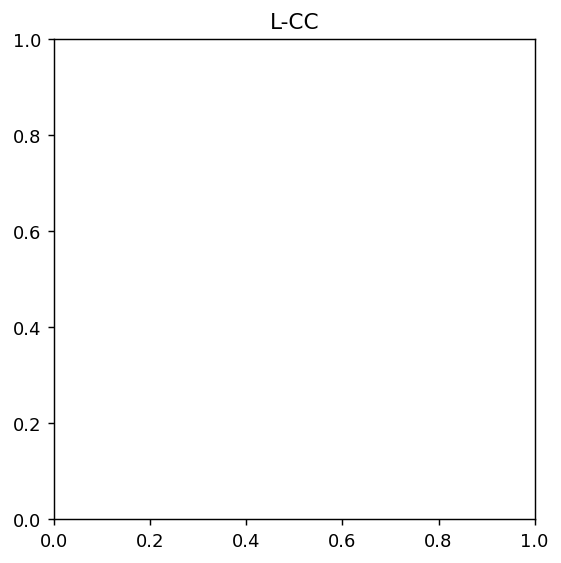

In [116]:
import matplotlib.pyplot as plt
import cv2 as cv

multi_view_df = meta_df[meta_df.acc_anon == '1000032271483397']

for laterality in ['L', 'R']:
    for view_position in ['CC', 'MLO']:
        df_subset = multi_view_df[(multi_view_df.ImageLateralityFinal == laterality) & (multi_view_df.ViewPosition == view_position)]
        n_images = len(df_subset)

        fig, axs = plt.subplots(1, n_images, dpi=130)
        for ax_idx, (i, row) in zip(range(n_images), df_subset.iterrows()):
            try:
                ax = axs[ax_idx]
            except TypeError:
                ax = axs
                
            ax.set_title(f'{laterality}-{view_position}')
            img = cv.imread(row.png_path)
            ax.imshow(img)

        fig.show()



> ## Question
>
> **How should we handle these cases?**